In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import BallTree
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, LineString
from pyproj import Proj, transform
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import os; os.chdir('../')
import warnings;warnings.simplefilter('ignore')
from scripts import datasources, models, variables
from choicemodels import MultinomialLogit
from choicemodels.tools import MergedChoiceTable

### Load data

Load UrbanSim data

In [90]:
jobs = orca.get_table('jobs').to_frame()
buildings = orca.get_table('buildings').to_frame()
parcels = orca.get_table('parcels').to_frame()

Load and format CHTS data for estimation

In [4]:
data_dir = '/home/data/fall_2018/'
chts_dir = 'CHTS_csv_format/'
chts_persons = pd.read_csv(data_dir + chts_dir + 'data/Deliv_PER.csv', low_memory=False)
chts_persons_lookup = pd.read_csv(data_dir + chts_dir + 'data/LookUp_PER.csv')
chts_households_lookup = pd.read_csv(data_dir + chts_dir + 'data/LookUp_Home.csv')

In [5]:
chts_persons = pd.merge(
    chts_persons.set_index(['SAMPN','PERNO']),
    chts_persons_lookup.set_index(['SAMPN','PERNO']),
    left_index=True, right_index=True,
    suffixes=('_persons', '_lookup')).reset_index()

chts_persons = pd.merge(
    chts_persons.set_index(['SAMPN']),
    chts_households_lookup.set_index(['SAMPN']),
    left_index=True, right_index=True).reset_index()

chts_persons = chts_persons[chts_persons['HCTFIP'].isin([1, 13, 41, 55, 75, 81, 85, 95, 97])].reset_index()

### Identify in-region workers

In [6]:
chts_persons['work_in_region'] = chts_persons['WCTFIP_lookup'].isin([1, 13, 41, 55, 75, 81, 85, 95, 97])

In [7]:
chts_persons['work_in_region'].value_counts()

False    13810
True     10220
Name: work_in_region, dtype: int64

### Get job coords

In [8]:
buildings = pd.merge(buildings, parcels[['x', 'y']], left_on='parcel_id', right_index=True)
jobs = pd.merge(jobs, buildings[['x', 'y']], left_on='building_id', right_index=True)
jobs.rename(columns={'x': 'lng', 'y': 'lat'}, inplace=True)

### Prepare jobs table and CHTS persons table for job assignment

In [9]:
jobs.loc[:,'taken'] = False
chts_persons.loc[:, 'job_id'] = None

In [10]:
# haversine requires data in form of [lat, lng] and inputs/outputs in units of radians
persons_work_rad = np.deg2rad(chts_persons[['WYCORD_lookup', 'WXCORD_lookup']])
jobs_rad = np.deg2rad(jobs[['lng', 'lat']])
jobs.loc[:, 'x'] = jobs_rad['lng']
jobs.loc[:, 'y'] = jobs_rad['lat']

### Assign CHTS persons a job ID

In [11]:
%%time

dists = []
no_job_info = []
no_work_coords = []
matched_on_industry = 0
matched_on_occupation = 0
matched_on_both = 0
matched_on_none = 0

for i, person in tqdm(chts_persons.iterrows(), total=len(chts_persons)):
    # only assign a job ID for employed persons with a fixed
    # work location other than their home
    if (person['EMPLY'] == 1) & (person['WLOC'] == 1) & (person['work_in_region'] == True):
        
        # skip person if no CHTS industry or occupation
        if (person['INDUS'] > 96) & (person['OCCUP'] > 96):
            no_job_info.append(i)
            continue
        
        # skip person if no work location
        elif pd.isnull(person[['WYCORD_lookup', 'WXCORD_lookup']]).any():
            no_work_coords.append(i)
            continue
        
        # if CHTS industry is unknown, match jobs based on occupation only
        elif person['INDUS'] > 96:
            potential_jobs = jobs[
                (jobs['occupation_id'] == person['OCCUP']) &
                (jobs['taken'] == False)]
            matched_on_occupation += 1
        
        # if occupation is unknown, match jobs based on industry only
        elif person['OCCUP'] > 96:
            potential_jobs = jobs[
                (jobs['sector_id'] == person['INDUS']) &
                (jobs['taken'] == False)]
            matched_on_industry += 1
            
        elif (person['INDUS'] < 97) & (person['OCCUP'] < 97):
            
            # define potential jobs based on industry and occupation
            potential_jobs = jobs[
                (jobs['sector_id'] == person['INDUS']) &
                (jobs['occupation_id'] == person['OCCUP']) &
                (jobs['taken'] == False)]
            
            # if no such jobs exist, define jobs by industry
            if len(potential_jobs) == 0:
                potential_jobs = jobs[
                    (jobs['sector_id'] == person['INDUS']) &
                    (jobs['taken'] == False)]
                matched_on_industry += 1
                
            # if no such jobs exist, define jobs by occupation
            if len(potential_jobs) == 0:
                potential_jobs = jobs[
                    (jobs['occupation_id'] == person['OCCUP']) &
                    (jobs['taken'] == False)]
                matched_on_occupation += 1
            
            # otherwise, continue
            if len(potential_jobs) == 0:
                matched_on_none += 1
                continue
            
            else:
                matched_on_both += 1
        
        # build the tree of potential jobs for fast nearest-neighbor search
        tree = BallTree(potential_jobs[['y','x']], metric='haversine')
        
        # query the tree for nearest job to each workplace
        dist, idx = tree.query(persons_work_rad.iloc[i].values.reshape(1,-1), return_distance=True)
        
        # save results
        job = potential_jobs.iloc[idx[0]]
        dists.append(dist[0][0])
        chts_persons.loc[i, 'job_id'] = job.index.values[0]
        jobs.loc[jobs.index.values == job.index.values[0], 'taken'] = True 


100%|██████████| 24030/24030 [26:41<00:00, 15.00it/s]

CPU times: user 26min 42s, sys: 3.94 s, total: 26min 46s
Wall time: 26min 41s


In [17]:
print('Assigned job IDs to {0}% of workers with a fixed work location.'.format(
    np.round(chts_persons.job_id.count() / len(
        chts_persons[(chts_persons['EMPLY'] == 1)  & (chts_persons['WLOC'] == 1)]) * 100, 1)))
print('{0}% had no industry/occupation info.'.format(
    np.round(len(no_job_info) / len(
        chts_persons[(chts_persons['EMPLY'] == 1)  & (chts_persons['WLOC'] == 1)]) * 100, 1)))
print('{0}% had no work coordinates.'.format(
    np.round(len(no_work_coords) / len(
        chts_persons[(chts_persons['EMPLY'] == 1)  & (chts_persons['WLOC'] == 1)]) * 100, 1)))
print('{0} workers were not assigned to jobs based on industry OR occupation.'.format(
    str(matched_on_none)))
print('{0} workers were assigned to jobs based on industry AND occupation.'.format(
    str(matched_on_both)))
print('{0} workers were assigned to jobs based on industry only.'.format(
    str(matched_on_industry)))
print('{0} workers were assigned to jobs based on occupation only.'.format(
    str(matched_on_occupation)))

Assigned job IDs to 96.5% of workers with a fixed work location.
1.7% had no industry/occupation info.
0.0% had no work coordinates.
0 workers were not assigned to jobs based on industry OR occupation.
8477 workers were assigned to jobs based on industry AND occupation.
283 workers were assigned to jobs based on industry only.
158 workers were assigned to jobs based on occupation only.


In [18]:
chts_persons.to_csv('data/chts_persons_w_jobs.csv', index=False)

Save the table so we don't have to re-run every time:

In [19]:
chts_persons = pd.read_csv('data/chts_persons_w_jobs.csv')

### Validate the work assignements

Compare the distance between the observed work location and the location of the job ID assigned in UrbanSim:

In [20]:
km_dists = [dist * 6371 for dist in dists]

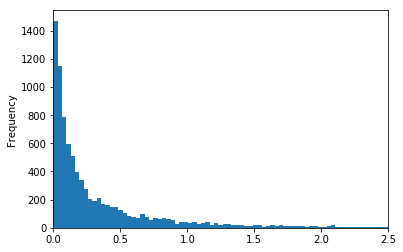

In [21]:
pd.Series(km_dists).plot(kind='hist', bins=1000, xlim=(0, 2.5))

Compare the distribution of jobs per census tract for the observed work locations versus those we assigned:

In [22]:
chts_workers = chts_persons[~pd.isnull(chts_persons['job_id'])]

In [23]:
# chts data
perwgt_tract_count = chts_workers.groupby('WTRACT_lookup').PERWGT.sum()
perwgt_cumsum = chts_workers.groupby('WTRACT_lookup').PERWGT.sum().reset_index().sort_values('WTRACT_lookup')['PERWGT'].cumsum().values
wtract_sorted = chts_workers.groupby('WTRACT_lookup').PERWGT.sum().reset_index().sort_values('WTRACT_lookup')['WTRACT_lookup'].values

In [24]:
# assignment data
merged = pd.merge(chts_workers, jobs, left_on='job_id', right_index=True)
merged = pd.merge(merged, buildings, left_on='building_id', right_index=True)
merged = pd.merge(merged, parcels, left_on='parcel_id', right_index=True)
merged['WTRACT_assigned'] = merged['block_id'].str[5:11].astype(int)
perwgt_tract_count_assigned = merged.groupby('WTRACT_assigned').PERWGT.sum()
perwgt_cumsum_assigned = merged.groupby('WTRACT_assigned').PERWGT.sum().reset_index().sort_values('WTRACT_assigned')['PERWGT'].cumsum().values
wtract_sorted_assigned = merged.groupby('WTRACT_assigned').PERWGT.sum().reset_index().sort_values('WTRACT_assigned')['WTRACT_assigned'].values

In [25]:
perwgts = pd.concat([perwgt_tract_count, perwgt_tract_count_assigned], axis=1)
perwgts.columns = ['chts', 'assigned']

Text(0,0.5,'assigned perwgt')

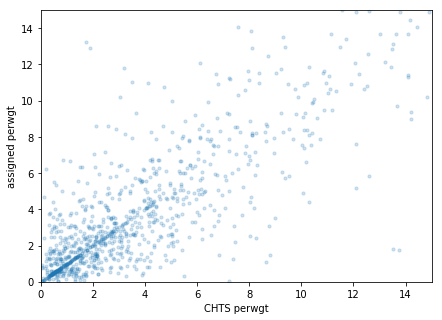

In [26]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(perwgts['chts'], perwgts['assigned'], alpha=0.2, s=10)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
ax.set_xlabel('CHTS perwgt')
ax.set_ylabel('assigned perwgt')

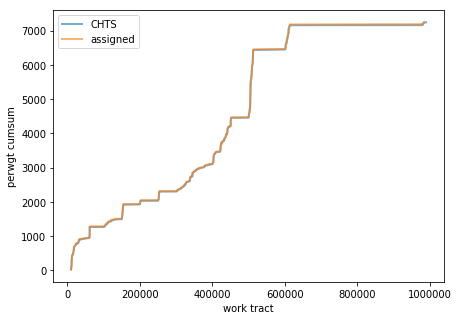

In [27]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(wtract_sorted, perwgt_cumsum, label='CHTS', lw=2, alpha=0.6)
ax.plot(wtract_sorted_assigned, perwgt_cumsum_assigned, label='assigned', lw=2, alpha=0.6)
ax.set_xlabel('work tract')
ax.set_ylabel('perwgt cumsum')
ax.legend()

### Assign CHTS persons to buildings

In [28]:
%%time
persons_home_rad = np.deg2rad(chts_persons[['HYCORD', 'HXCORD']])
bldg_rad = np.deg2rad(buildings[['y', 'x']])
buildings.loc[:, 'x_rad'] = bldg_rad['x']
buildings.loc[:, 'y_rad'] = bldg_rad['y']
tree = BallTree(buildings[['y_rad','x_rad']], metric='haversine')
dists, idxs = tree.query(persons_home_rad, return_distance=True)

CPU times: user 20.8 s, sys: 388 ms, total: 21.2 s
Wall time: 21.2 s


In [29]:
km_dists = pd.Series([dist[0] * 6371 for dist in dists])

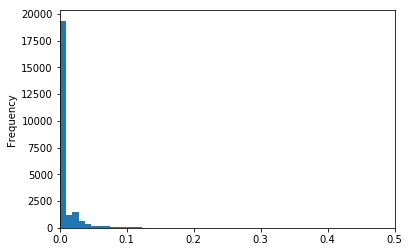

In [30]:
pd.Series(km_dists).plot(kind='hist', bins=100, xlim=(0,0.5))

Save the updated persons table so we don't have to re-run every time:

In [31]:
chts_persons['building_id'] = buildings.iloc[idxs[:,0]].index
chts_persons.to_csv('./data/chts_persons_w_jobs_and_res_bldgs.csv', index=False)

In [6]:
chts_persons = pd.read_csv('./data/chts_persons_w_jobs_and_res_bldgs.csv')

### Generate Accessibility Vars

In [8]:
%%time
orca.run(['initialize_network_small', 'network_aggregations_small'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 13.01 s
Running step 'network_aggregations_small'
Computing accessibility variables
Computing units_10000
Computing units_sf_10000
Computing units_mf_10000
Computing pop_10000
Removed 189769 rows because they contain missing values
Computing hh_10000
Removed 189769 rows because they contain missing values
Computing poor_10000
Removed 53114 rows because they contain missing values
Computing renters_10000
Removed 102597 rows because they contain missing values
Computing avg_income_10000
Removed 189769 rows because they contain missing values
Computing jobs_10000
Computing avg_rent_10000
Computing pop_white_10000
Removed 107372 rows because they contain missing values
Computing pop_black_10000
Removed 10541 rows because they contain missing values
Computing pop_asian_10000
Removed 51048 rows because they contain missing values
Computing pop_hisp_10000
Removed 31685 rows because they contain missing va

In [9]:
%%time
orca.run(['initialize_network_walk','network_aggregations_walk'])

Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 19.03 s
Running step 'network_aggregations_walk'
Computing accessibility variables
Computing units_500_walk
Computing sqft_unit_500_walk
Computing singles_500_walk
Removed 52084 rows because they contain missing values
Computing elderly_hh_500_walk
Removed 34553 rows because they contain missing values
Computing children_500_walk
Removed 189769 rows because they contain missing values
Computing units_sf_500_walk
Computing units_mf_500_walk
Computing pop_500_walk
Removed 189769 rows because they contain missing values
Computing hh_500_walk
Removed 189769 rows because they contain missing values
Computing poor_500_walk
Removed 53114 rows because they contain missing values
Computing rich_500_walk
Removed 38964 rows because they contain missing values
Computing renters_500_walk
Removed 102597 rows because they contain missing values
Computing avg_income_500_walk
Removed 189769 rows because they contain 

In [10]:
walk_net_vars = orca.get_table('nodeswalk').to_frame()
drive_net_vars = orca.get_table('nodessmall').to_frame()

In [88]:
walk_net_vars.head()

,units_500_walk,sqft_unit_500_walk,singles_500_walk,elderly_hh_500_walk,children_500_walk,units_sf_500_walk,units_mf_500_walk,pop_500_walk,hh_500_walk,poor_500_walk,...,jobs_2500_walk_retail,jobs_500_walk_fire,jobs_1500_walk_fire,jobs_2500_walk_fire,jobs_500_walk_tech,jobs_1500_walk_tech,jobs_2500_walk_tech,jobs_500_walk_serv,jobs_1500_walk_serv,jobs_2500_walk_serv
osmid,,,,,,,,,,,,,,,,,,,,,
25457938,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2311.0,11.0,22.0,145.0,7.0,56.0,217.0,128.0,502.0,894.0
25457939,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1712.0,5.0,34.0,105.0,14.0,55.0,220.0,295.0,563.0,712.0
26027651,336.0,1000.871399,86.0,153.0,178.0,66.0,270.0,783.0,334.0,68.0,...,2806.0,64.0,222.0,1139.0,92.0,750.0,4801.0,31.0,353.0,942.0
26027655,340.0,2389.937500,126.0,27.0,114.0,46.0,294.0,616.0,310.0,52.0,...,3366.0,76.0,434.0,940.0,66.0,526.0,1402.0,26.0,886.0,1541.0
26027656,154.0,884.079224,44.0,50.0,94.0,102.0,52.0,362.0,143.0,25.0,...,3271.0,217.0,663.0,956.0,327.0,737.0,1068.0,373.0,1152.0,1763.0


In [108]:
drive_net_vars.head()

,units_10000,units_sf_10000,units_mf_10000,pop_10000,hh_10000,poor_10000,renters_10000,avg_income_10000,jobs_10000,avg_rent_10000,...,pop_asian_25000,pop_hisp_25000,jobs_10000_retail,jobs_25000_retail,jobs_10000_fire,jobs_25000_fire,jobs_10000_tech,jobs_25000_tech,jobs_10000_serv,jobs_25000_serv
osmid,,,,,,,,,,,,,,,,,,,,,
281266,92842.0,57296.0,35188.0,202694.0,81570.0,12582.0,30775.0,144690.687500,114844.0,3243.214111,...,200427.0,165284.0,15786.0,50250.0,16376.0,31264.0,29478.0,61302.0,7645.0,28414.0
302878,127751.0,75954.0,51797.0,294196.0,110588.0,16770.0,45203.0,155366.765625,83311.0,3053.273926,...,450411.0,274079.0,14775.0,84271.0,6719.0,39882.0,10979.0,92341.0,8247.0,48141.0
302883,141337.0,85085.0,56252.0,325863.0,122376.0,18621.0,49176.0,154314.421875,88282.0,3027.604980,...,470964.0,302104.0,15616.0,85593.0,7638.0,41506.0,11141.0,92970.0,9367.0,48975.0
302888,141378.0,86772.0,54606.0,329189.0,122302.0,19061.0,48626.0,151341.765625,84517.0,3022.447754,...,483542.0,298849.0,15554.0,85543.0,7311.0,41104.0,8861.0,91751.0,9366.0,49327.0
15972513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,14.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save the network accessibility variables tables so we don't have to re-run every time:

In [80]:
walk_net_vars.to_csv('./data/walk_net_vars.csv')
drive_net_vars.to_csv('./data/drive_net_vars.csv')

### Generate the interaction terms (travel time)

In [3]:
skims = pd.read_csv('./data/TimeSkimsDatabaseAM.csv')

In [4]:
interaction_terms = skims[['orig', 'dest', 'da', 'wTrnW']].rename(
    columns={'orig': 'zone_id_home', 'dest': 'zone_id_work', 'da': 'tt_da', 'wTrnW': 'tt_wTrnW'})

In [5]:
interaction_terms.set_index(['zone_id_home', 'zone_id_work'], inplace=True)

In [6]:
interaction_terms.head()

tt_da  tt_wTrnW
zone_id_home zone_id_work                 
1            1              5.80   -999.00
             2              6.13      7.20
             3              6.59      9.70
             4              6.63      6.10
             5              7.28      7.42

In [7]:
interaction_terms.to_csv('./data/WLCM_interaction_terms.csv')

### Generate the merged choice table

In [6]:
chts_persons = pd.read_csv('./data/chts_persons_w_jobs_and_res_bldgs.csv')
chts_workers = chts_persons[~pd.isnull(chts_persons['job_id'])]
orca.run(['initialize_network_walk', 'initialize_network_small'])
buildings = orca.get_table('buildings').to_frame()
parcels = orca.get_table('parcels').to_frame()
jobs = orca.get_table('jobs').to_frame()
interaction_terms = pd.read_csv('./data/WLCM_interaction_terms.csv', index_col=['zone_id_home', 'zone_id_work'])
walk_net_vars = pd.read_csv('./data/walk_net_vars.csv', index_col='osmid')
drive_net_vars = pd.read_csv('./data/drive_net_vars.csv', index_col='osmid')

Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


In [8]:
obs = chts_workers.merge(buildings, left_on='building_id', right_index=True).merge(
    parcels, left_on='parcel_id', right_index=True)[['job_id', 'zone_id']].rename(columns={'zone_id':'zone_id_home'})
obs.index.name = 'obs_id'

In [9]:
alts = jobs.merge(buildings, left_on='building_id', right_index=True).merge(
    parcels, left_on='parcel_id', right_index=True).merge(
    walk_net_vars, left_on='node_id_walk', right_index=True).merge(
    drive_net_vars, left_on='node_id_small', right_index=True).rename(columns={'zone_id': 'zone_id_work'})

In [10]:
alts = alts[['jobs_1500_walk', 'jobs_25000', 'zone_id_work']]

In [11]:
%%time
mct = MergedChoiceTable(obs, alts, chosen_alternatives='job_id',
                        sample_size=10, interaction_terms=interaction_terms)

CPU times: user 654 ms, sys: 77.6 ms, total: 732 ms
Wall time: 738 ms


In [12]:
mct.to_frame().head(11)

zone_id_home  jobs_1500_walk  jobs_25000  zone_id_work  \
obs_id job_id                                                              
24022  13503.0             654          4060.0    658449.0           383   
       659800.0            654          2455.0    617767.0           750   
       309068.0            654          1077.0    496964.0           685   
       1518679.0           654         36812.0    777759.0           967   
       1163028.0           654          3626.0    352113.0           810   
       1522374.0           654         45218.0    806298.0           970   
       430273.0            654           282.0    425964.0           656   
       1576764.0           654         22699.0    777707.0           966   
       230219.0            654          9365.0    615698.0           534   
       2577533.0           654          1204.0    171571.0          1214   
24021  160706.0            654          7243.0    724837.0           414   

                  chosen  tt_da  tt_wTrnW  
obs_id job_id                              
24022  13503.0         1  41.47    158.59  
       659800.0        0  32.77    112.09  
       309068.0        0  26.76    120.22  
       1518679.0       0  71.21   -999.00  
       1163028.0       0  56.75   -999.00  
       1522374.0       0  74.02   -999.00  
       430273.0        0  16.91   -999.00  
       1576764.0       0  69.58   -999.00  
       230219.0        0  28.74    107.29  
       2577533.0       0  84.27   -999.00  
24021  160706.0        1  30.42    108.09

### Occupation counts

In [83]:
chts_workers.merge(jobs, left_on='job_id', right_index=True)['occupation_id'].value_counts()

11    1437
25    1066
13     776
43     720
15     676
41     654
17     574
29     518
19     297
35     285
31     242
23     227
53     182
27     180
21     179
49     169
39     150
51     141
37     139
33     139
47     102
45      34
55      18
97       7
99       4
98       2
Name: occupation_id, dtype: int64

### Estimate the WLCM

In [13]:
m = LargeMultinomialLogitStep()
m.name = 'WLCM'

In [38]:
m.model_expression = 'np.log1p(jobs_1500_walk) + np.log(jobs_25000) + np.log1p(tt_da) + tt_wTrnW - 1'

In [39]:
m.fit(mct)

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          8,918
Model:         Multinomial Logit   Df Residuals:              8,914
Method:       Maximum Likelihood   Df Model:                      4
Date:                 2018-09-26   Pseudo R-squ.:             0.411
Time:                      20:29   Pseudo R-bar-squ.:         0.411
AIC:                  24,200.705   Log-Likelihood:      -12,096.352
BIC:                  24,229.088   LL-Null:             -20,534.454
                              coef   std err          z     P>|z|   Conf. Int.
------------------------------------------------------------------------------
np.log1p(jobs_1500_walk)    0.0719     0.008      9.003     0.000             
np.log(jobs_25000)          0.1237     0.007     17.655     0.000             
np.log1p(tt_da)            -2.3485     0.022   -108.200     0.000             
tt_wTrnW                    0.0001     0.000      4.800     0

In [42]:
mm.initialize()

No files from ModelManager 0.1.dev8 or later found in path 'configs'


In [43]:
mm.register(m)

Saving 'WLCM.yaml': /home/max/projects/ual_model_workspace/fall-2018-models/configs
Registering model step 'WLCM'
